In [52]:
import pandas as pd
import ast
from gensim.models import Word2Vec
import os
import tensorflow as tf
from tensorboard.plugins import projector
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline



In [53]:
df = pd.read_csv('clean_avis_v1.csv')
del(df['Unnamed: 0'])


In [54]:
df.head()

,note,assureur,produit,date_exp,avis_cor,avis_cor_en,avis_clean_fr,avis_clean_en,avis_token_fr,avis_token_en
0,5.0,Direct Assurance,auto,01/09/2021,"Meilleurs assurances , prix , solutions , écou...","Best insurance , price , solutions , listening...",meilleurs assurances prix solutions écoute rap...,best insurance price solutions listening speed...,"['meilleurs', 'assurances', 'prix', 'solutions...","['best', 'insurance', 'price', 'solutions', 'l..."
1,4.0,Direct Assurance,auto,01/05/2021,"je suis globalement satisfait , sauf que vous ...","I am generally satisfied , except that you hav...",globalement satisfait sauf problème site inter...,generally satisfied except problem website imp...,"['globalement', 'satisfait', 'sauf', 'problème...","['generally', 'satisfied', 'except', 'problem'..."
2,5.0,Direct Assurance,auto,01/03/2021,Prix tres abordable plusieurs options s'offren...,Very affordable price Several options are avai...,prix tres abordable plusieurs options soffrent...,affordable price several options available us ...,"['prix', 'tres', 'abordable', 'plusieurs', 'op...","['affordable', 'price', 'several', 'options', ..."
3,4.0,L'olivier Assurance,auto,01/06/2021,"je satisfait du service , une réponse très rap...","I satisfy the service , a very fast response f...",satisfait service réponse très rapide service ...,satisfy service fast response service thank ch...,"['satisfait', 'service', 'réponse', 'très', 'r...","['satisfy', 'service', 'fast', 'response', 'se..."
4,1.0,Matmut,auto,01/01/2017,"Client depuis plus de 25 ans , très déçu de ce...","Customer for more than 25 years , very disappo...",client depuis plus ans très déçu cette mutuel...,customer years disappointed mutual longer mut...,"['client', 'depuis', 'ans', 'très', 'déçu', 'm...","['customer', 'years', 'disappointed', 'mutual'..."


In [55]:
df['avis_token_en'] = df['avis_token_en'].apply(ast.literal_eval)
df['avis_token_fr'] = df['avis_token_fr'].apply(ast.literal_eval)

In [56]:


model_fr = Word2Vec(sentences=df['avis_token_fr'], vector_size=100, window=20, min_count=200, workers=4)

model_fr.save("word2vec_model")



In [57]:

model_en = Word2Vec(sentences=df['avis_token_en'], vector_size=100, window=20, min_count=200, workers=4)

model_en.save("word2vec_model_en")


In [11]:
#Export pour visu Tensorboard
vectors = model_fr.wv.vectors
words = model_fr.wv.index_to_key

metadata_df = pd.DataFrame(words, columns=['Word'])

metadata_df.to_csv('metadata.tsv', sep='\t', index=False,header=False)

with open('vectors.tsv', 'w', encoding='utf-8') as f:
    for vector in vectors:
        vector_line = '\t'.join(str(value) for value in vector)
        f.write(f"{vector_line}\n")

print("Exported vectors.tsv and metadata.tsv successfully.")

Exported vectors.tsv and metadata.tsv successfully.


In [ ]:
import matplotlib.pyplot as plt

model = Word2Vec(sentences=df['avis_tokenized'], vector_size=100, window=20, min_count=200, workers=4)

vocab = []
for i in range(0,len(model.wv)):
        vocab.append(model.wv.index_to_key[i])



def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in vocab:
        tokens.append(model.wv[word])
        labels.append(word)
        #print(tokens)
        #print(labels)
    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)


    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    

tsne_plot(model)


In [50]:
def cosine_similarity(word1,word2):
    
    return model_fr.wv.similarity(word1,word2)

In [58]:
def most_similar_words(word, model, topn=5):
    try:
        similar_words = model.wv.most_similar(word, topn=topn)
        return similar_words
    except KeyError:
        return f"The word '{word}' is not in the vocabulary."


In [61]:
most_similar_words("voiture", model_fr)

[('vehicule', 0.8452456593513489),
 ('garage', 0.7874598503112793),
 ('lassistance', 0.7833312749862671),
 ('risque', 0.7790943384170532),
 ('panne', 0.7755792140960693)]

In [62]:
cosine_similarity('assurance','voiture')

0.36168456

In [126]:


df['avis_tokenized_str'] = df['avis_tokenized'].apply(lambda tokens: ' '.join(tokens))
X_train, X_test, y_train, y_test = train_test_split(
    df['avis_tokenized_str'], df['note'], test_size=0.2, random_state=42
)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  
classifier = MultinomialNB()

model = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', classifier)
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


Accuracy: 0.52
Classification Report:
               precision    recall  f1-score   support

         1.0       0.55      0.96      0.70      1398
         2.0       0.51      0.03      0.06       754
         3.0       0.36      0.05      0.08       664
         4.0       0.45      0.45      0.45       951
         5.0       0.54      0.68      0.60       935

    accuracy                           0.52      4702
   macro avg       0.48      0.43      0.38      4702
weighted avg       0.49      0.52      0.44      4702



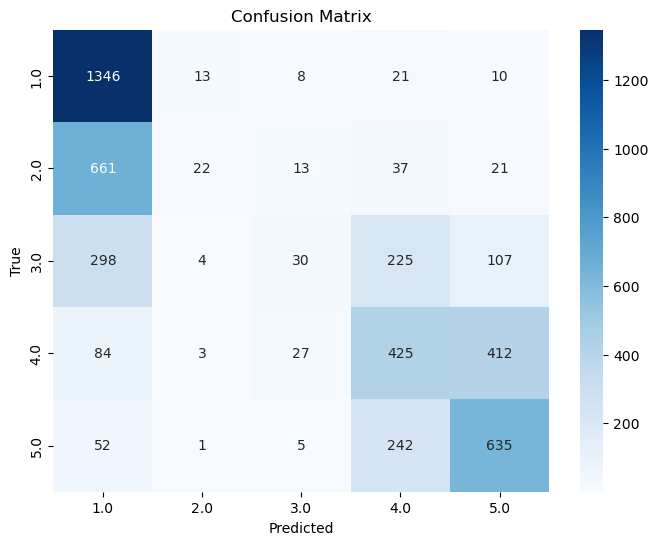

In [128]:


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['note'].unique()), yticklabels=sorted(df['note'].unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()